# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Callable

In [2]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (n, p) and a line 
    vector with the m class labels in {0, ..., 9}
    """
    # citire date sin fisierul dat de path
    df = pd.read_csv(path, header=None)
    X = df[df.columns[1:]].T
    y = df[df.columns[0]].to_frame().T
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (1, X.shape[1]), 'Same number of lines is required'
    return X, y

In [3]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

In [4]:
X_train, y_train = load_file(path_train)
assert X_train.shape == (784, 60000)
assert y_train.shape == (1, 60000)

X_test, y_test = load_file(path_test)
assert X_test.shape == (784, 10000)
assert y_test.shape == (1, 10000)

In [5]:
def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    result = np.array(X) / 255
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [6]:
X_train = scale_values(X_train)
assert X_train.shape == (784, 60000)
X_test = scale_values(X_test)
assert X_test.shape == (784, 10000)

# Create model

## Define model's architecture

In [7]:
m = 10 # number of classes
n, p = X_train.shape
architecture = [n, 100, m] # list: [input_size, hidden1, hidden2, ..., output_size]

assert len(architecture) >= 3, 'At least one hidden layer'
assert architecture[0] == n
assert architecture[-1] == m

Ponderile sunt initializate conform strategiei lui Xavier Glorot. Pentru o matrice de ponderi $W^{[l]}$ de forma $n_{l} \times n_{l-1}$, ponderile pot fi initializate cu o distributie uniforma in intervalul 
$$
\left[-\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}, +\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}\right]
$$

Ponderile de bias se obisnuiesc a se initializa cu 0; intializarea aleatoare a ponderilor W este considerata suficienta pentru a obtine spargerea simetriei.

Ref: [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [8]:
def create_weights(architecture: List[int], init_type:str='glorot_uniform') -> Tuple[List[np.array], List[np.array]]:
    """Creates the list of weights and biases for the given architecture.
    :param architecture: list of number of nodes in each layer 
    (including input and ouotput layers)
    :param init_type: name of initialization parameter. Defaults to 
    'glorot_uniform', add other supported initializtion strategies.
    :return: a tuple containing: list of weight matrices W, a list of bias 
    column vectors. The two lists have the same numer of elements, number of 
    layers - 1.
    """
    L = len(architecture)
    W, b = [], []
    # initializare de ponderi
    for n_lplus1, nl in zip(architecture[1:], architecture[:-1]):
        W.append(np.random.uniform(- np.sqrt(6)/np.sqrt(nl + n_lplus1), np.sqrt(6)/np.sqrt(nl + n_lplus1), (n_lplus1, nl)))
    for n_l in architecture[1:]:
        b.append(np.zeros((n_l, 1)))
    assert len(W) == len(b) == L-1
    for i, w in enumerate(W):
        assert w.shape == (architecture[i+1], architecture[i]), f'Shape of W[{i}] should be (L[{i+1}], L[{i}])'
    for i, _b in enumerate(b):
        assert _b.shape == (architecture[i+1], 1), f'Shape of b[{i}] should be (L[{i+1}], 1)'
    if init_type == 'glorot_uniform':
        for i, w in enumerate(W):
            w_shape_sum = np.sum(w.shape)
            assert -np.sqrt(6)/np.sqrt(w_shape_sum) <= np.min(w) <= np.sqrt(6)/np.sqrt(w_shape_sum), f"Values of W[{i}] should be according to Glorot's initialization"
        for i, _b in enumerate(b):
            assert 0 == np.min(_b) == np.min(_b) == 0, f"Values of b[{i}] should be initialized to 0"
    return W, b

Activation functions:
- Logistic sigmoid:
$$f = \sigma : \mathbb{R} \rightarrow (0, 1), f(z) = \sigma(z) = \frac{1}{1 + \exp{(-z)}}$$
and its derivative:
$$f'(z) = \sigma'(z) = \sigma(z)(1 - \sigma(z)) = f(z) \cdot (1 - f(z))$$
- Hyperbolic tangent:
$$f = \tanh : \mathbb{R} \rightarrow (-1, 1), f(z) = \tanh(z) = \frac{\exp(z) - \exp(-z)}{\exp(z) + \exp(-z)}$$
and its derivative:
$$f'(z) = \tanh'(z) = 1 - \tanh^2(z) = 1 - f^2(z)$$
- Rectified Linear Unit (ReLU):
$$f(x) = \max(0, x) = \begin{cases} 0 & \text{if } x \leq 0 \\ x & \text{if } x > 0 \end{cases}$$
and its derivative:
$$f'(x) = \begin{cases} 0 & \text{if } x \leq 0 \\ 1 & \text{if } x > 0 \end{cases}$$

In [9]:
def sigmoid(z: np.array) -> np.array:
    """Computes sigmoid activation function"""
    return 1/(1+np.exp(-z))

def derivative_sigmoid(z: np.array) -> np.array:
    """Computes the derivatives for the sigmoid activation function"""
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z: np.array) -> np.array:
    """Computes the tanh activation function"""
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def derivative_tanh(z: np.array) -> np.array:
    """Computes the derivatives for the tanh activation function"""
    return 1 - tanh(z)**2

def ReLU(z: np.array) -> np.array:
    """Computes the rectified linear unit activation function"""
    return (z > 0) * z 

def derivative_ReLU(z: np.array) -> np.array:
    """Computes the derivatives of the rectified linear unit activation function"""
    return np.heaviside(z, 0) # one-liner of thr = 0, z[z <= 0] = 0, z[z == 0] = thr, z[z > 0] = 1

In [10]:
def softmax(z, axis=0):
    """Applies softmax to a matrix z.
    :param z: np.array of shape (m, k)
    """
    exp_z = np.exp(z - np.max(z))
    result = exp_z / exp_z.sum(axis=axis)
    assert exp_z.shape == z.shape
    assert np.allclose(np.sum(result, axis=axis), 1.0)
    return result

In [11]:
W, b = create_weights(architecture=architecture)

## Feedforward propagation

In [12]:
def can_multiply(a:np.array, b:np.array) -> bool:
    return a.ndim == b.ndim == 2 and a.shape[1] == b.shape[0]

def can_multiply_hadamard(a:np.array, b:np.array) -> bool:
    return a.shape == b.shape

Formulele 6.18 - 6.21 din curs:
$$\Large \textbf{a}^{(1)} = \textbf{x}$$
$$\Large \textbf{z}^{(l)} = \textbf{W}^{(l-1)} \cdot \textbf{a}^{(l-1)} + \textbf{b}^{(l-1)}$$
$$\Large \textbf{a}^{(l)} = f^{(l)}(\textbf{z}^{(l)}), f^{(l)}(\cdot), l = 2, ..., L$$
$$\Large \textbf{o} = \textbf{a}^{(L)}$$

In [15]:
def model(X:np.array, W:List[np.array], b:List[np.array], f:List[Callable]):
    """Computes the output produced by the MLP for the given input X
    :param X: np.array of shape (n, p). Each column of X is a datum from a set.
    :param W: a list of weight matrices
    :param b: a list of bias columns
    :param f: a list of activation functions
    :return: a matrix of output values produced by MLP, of shape: number of 
    predicted outputs (e.g. classes), number of input vectors p
    """
    assert len(W) == len(b) == len(f)
    p = X.shape[1]
    a = X
    Z, A = [], [a]
    for i, (_w, _b, _f) in enumerate(zip(W, b, f)):
        # variabila i poate fi folosita pentru debug
        assert can_multiply(_w, a)
        z = _w @ a + _b
        Z.append(z)
        assert z.shape == (_w.shape[0], p)
        a = _f(z)
        A.append(a)
        assert a.shape == z.shape
    assert a.shape == (W[-1].shape[0], p)
    return a, Z, A

In [16]:
# f[0] = functia de activare pe primul strat ascuns; 
# f[1] = functia de activare pe al doilea strat ascuns etc.
f = [sigmoid, softmax]
y_hat, _, _ = model(X_train, W, b, f)

assert y_hat.shape == (m, p)
assert np.allclose(y_hat.sum(axis=0), np.ones(p))

## Error function

$$\Large J(\textbf{W}, \textbf{b}) = - \frac{1}{p} \sum_{i=1}^p \sum_{j=1}^m d_j^{(i)} \log o_j^{(i)} + \frac{\lambda}{2} \sum_{l=1}^{L-1} \left\lVert \textbf{W}^{(l)} \right\rVert_F^2$$

In [17]:
def J(X, y, W, b, f, num_classes=10, _lambda=0.01):
    """Computes the error function for MLP
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k)
    :param W: list pf MLPs weights
    :param b: list pf MLPs biases
    :return: loss values, composed of cross entropy + penalty term
    """
    p = X.shape[1]
    EPS = 1e-5
    # computes a one hot encoding for the given classes:
    # if y[i]=c, 0 <= c <= 9 (here), then column i in one_hot_encoding is filled
    # in with 0, excepting line c where one finds value 1
    y_ohe = np.zeros((num_classes, p))
    y_ohe[y, np.arange(y_ohe.shape[1])] = 1
    assert np.all(y_ohe.sum(axis=0) == 1)
    predicted, _, _ = model(X, W, b, f)
    predicted = np.clip(predicted, EPS, 1-EPS)
    loss1 = (-1/p) * np.sum(y_ohe * np.log10(predicted))
    W_frobenius_norms_sq = [np.linalg.norm(w, ord='fro')**2 for w in W]
    loss2 = _lambda/2 * np.sum(np.array(W_frobenius_norms_sq))
    return loss1 + loss2

In [18]:
def accuracy(X:np.array, y:np.array, W: List[np.array], b: List[np.array], f:List[Callable]) -> float:
    """Computes the accuracy on a given input dataset X, with ground truth y
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k); each value is the index of a class
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activation functions. the last one must be softmax
    :return: ratio between correctly classified vectors and total number of cases
    """
    p = X.shape[1]
    y_hat, _, _ = model(X, W, b, f)
    y_ohe = np.zeros((10, p))
    y_ohe[y, np.arange(y_ohe.shape[1])] = 1
    y_predicted = np.zeros_like(y_hat)
    y_predicted[y_hat.argmax(axis=0), np.arange(y_hat.shape[1])] = 1
    return (np.logical_and(y_predicted == y_ohe, y_ohe == 1)).sum() / X.shape[1]

# Train model

In [19]:
def backpropagation(architecture: List[int], X: np.array, d: np.array, W: List[np.array], b:List[np.array], num_classes, _lambda:float, alpha:float):
    DW, Db = [], []
    f_deriv = [derivative_sigmoid]
    for n_lplus1, nl in zip(architecture[1:], architecture[:-1]):
        DW.append(np.zeros((n_lplus1, nl)))
    for n_l in architecture[1:]:
        Db.append(np.zeros((n_l, 1)))
    p = X.shape[1]
    L = len(architecture)-1 # L = 2

    for digit in range(0, p):
        d_ohe = np.zeros((num_classes, 1))
        d_ohe[d[digit], 0] = 1
        o_ohe, Z, A = model(X[:,digit].reshape(-1,1), W, b, f)
        delta = []
        
        delta.append(o_ohe - d_ohe)

        for l in range(L-1, 0, -1):
            delta.append((W[l].T @ delta[L-1-l]) * f_deriv[l-1](Z[l-1]))
        
        dJdW, dJdb = [], []
        for l in range(0, L):
            dJdW.append(delta[L-1-l] @ A[l].T)
            dJdb.append(delta[L-1-l])

        for l in range(0, L):
            DW[l] = DW[l] + dJdW[l]
            Db[l] = Db[l] + dJdb[l]
            
    for l in range(0, L):
        W[l] = W[l] - alpha * ((1/p * DW[l]) + _lambda * W[l])
        b[l] = b[l] - alpha * (1/p * Db[l])
    return W, b

In [20]:
def train(architecture: List[int], X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, num_classes, W: List[np.array], b:List[np.array], f:List[Callable], _lambda: float, alpha: float, max_delta_error:float=5e-3) -> Tuple[List[np.array], List[np.array], List[float], List[float], List[float]]:
    """Runs the training on the training dataset (X, y). Stops when  
    difference between  two succesive error values is lower than :param max_delta_error:
    :param X_train: np.array of shape (n, k), with training cases. Each column is a training case
    :param y_train: np.array of shape (1, k), containing labels (0=class 0, ...)
    :param X_test: np.array of shape (n, l), with test cases. Each column is a test vector
    :param y_test: np.array of shape (1, l), containing labels (0=class 0, ...)
    :param num_classes: number of classes
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activations functions; the last one must be softmax
    :param _lambda: coefficient >= for the L2 penalty term
    :param alpha: > 0, learning rate
    :max_delta_error: >0, a threshold for max absolute difference of succesive loss values
    :return: a tuple consisting of: list of weight matrices, list of biases, list of errors computed at each epoch on training set, 2 lists of accuracies on training and on test set at each epoch
    """
    errors_train = [J(X_train, y_train, W, b, f, num_classes, _lambda)]
    errors_test = [J(X_test, y_test, W, b, f, num_classes, _lambda)]
    acc_train = [accuracy(X_train, y_train, W, b, f)]
    acc_test = [accuracy(X_test, y_test, W, b, f)]
    epoch = 0
    
    print(f'Epoch: {epoch}, error: {errors_train[0]}, train accuracy: {acc_train[0]}, test accuracy: {acc_test[0]}')
    p = X_train.shape[1]
    while True:
        epoch += 1
        # actualizare ponderi si biases W, b pentru fiecare pereche de date din setul de instruire *_test
        W, b = backpropagation(architecture, X_train, y_train, W, b, num_classes, _lambda, alpha)
        
        error_train = J(X_train, y_train, W, b, f, num_classes, _lambda)
        error_test = J(X_test, y_test, W, b, f, num_classes, _lambda)
        
        errors_train.append(error_train)
        errors_test.append(error_test)
        
        train_acc = accuracy(X_train, y_train, W, b, f)
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, W, b, f)
        acc_test.append(test_acc)
        
        print(f'Epoch: {epoch}, error: {error_train}, train accuracy: {train_acc}, test accuracy: {test_acc}')
        if np.abs(errors_train[-1] - errors_train[-2]) < max_delta_error:
            break
        # plot de valore de eroare pe train si pe test
        plt.plot(errors_train, label='Loss on train DS', color='r')
        plt.plot(errors_test, label='Loss on test DS', color='b')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    return W, b, errors_train, acc_train, acc_test

Epoch: 0, error: 2.1379114645549633, train accuracy: 0.11233333333333333, test accuracy: 0.1141
Epoch: 1, error: 2.008260561011109, train accuracy: 0.14883333333333335, test accuracy: 0.1573


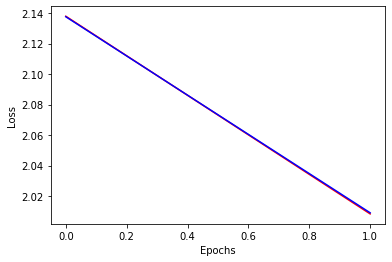

Epoch: 2, error: 1.9079478675301758, train accuracy: 0.29788333333333333, test accuracy: 0.2956


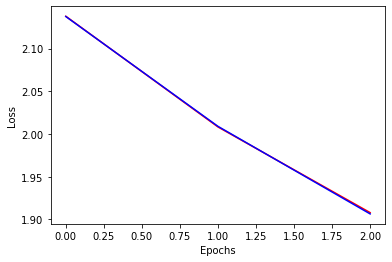

Epoch: 3, error: 1.8729563941059806, train accuracy: 0.42323333333333335, test accuracy: 0.4301


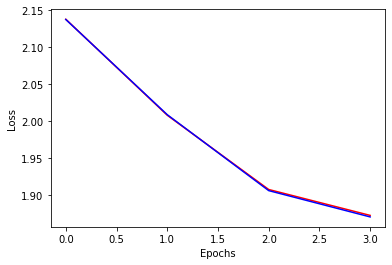

Epoch: 4, error: 1.8413960389135418, train accuracy: 0.5350666666666667, test accuracy: 0.55


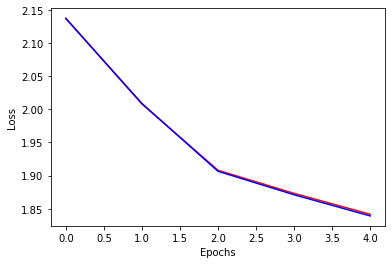

Epoch: 5, error: 1.8117968378231049, train accuracy: 0.5803166666666667, test accuracy: 0.5967


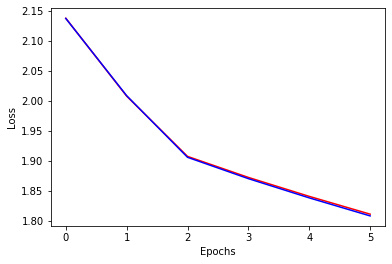

Epoch: 6, error: 1.783552921800542, train accuracy: 0.6203333333333333, test accuracy: 0.6365


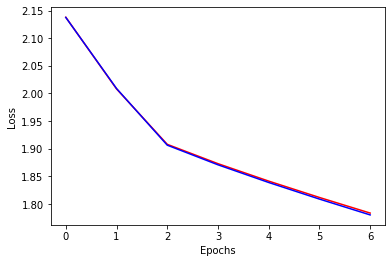

Epoch: 7, error: 1.7564702563926102, train accuracy: 0.6443833333333333, test accuracy: 0.6614


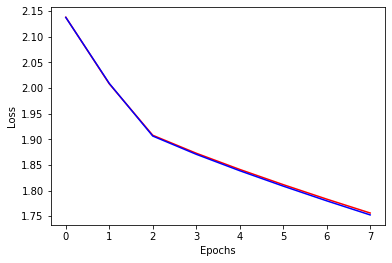

Epoch: 8, error: 1.7304308399090567, train accuracy: 0.6663, test accuracy: 0.6853


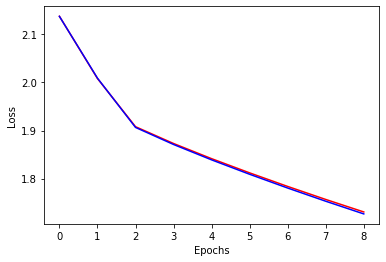

Epoch: 9, error: 1.7053563767684905, train accuracy: 0.6828666666666666, test accuracy: 0.7023


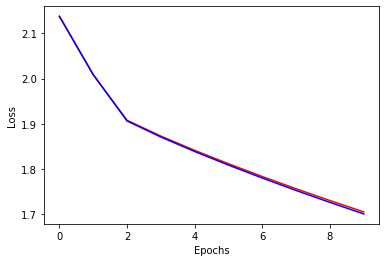

Epoch: 10, error: 1.6811893610746762, train accuracy: 0.6971, test accuracy: 0.7161


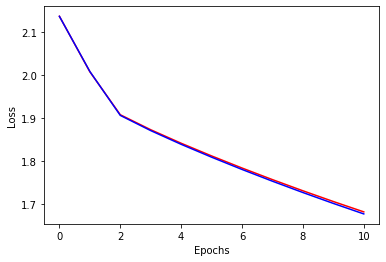

Epoch: 11, error: 1.6578874579356357, train accuracy: 0.7094833333333334, test accuracy: 0.7288


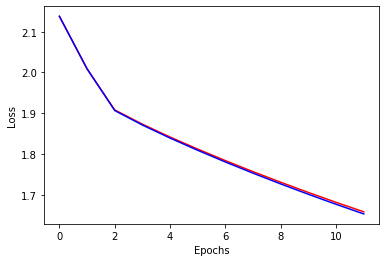

Epoch: 12, error: 1.6354190883193533, train accuracy: 0.7203833333333334, test accuracy: 0.738


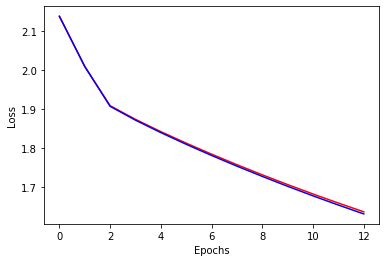

Epoch: 13, error: 1.6137599359858874, train accuracy: 0.7299166666666667, test accuracy: 0.7464


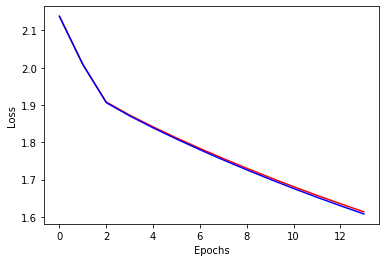

Epoch: 14, error: 1.5928904038045921, train accuracy: 0.7378333333333333, test accuracy: 0.7559


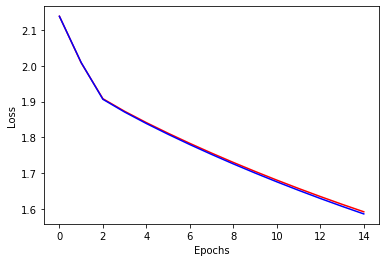

Epoch: 15, error: 1.572793374833404, train accuracy: 0.7446666666666667, test accuracy: 0.7621


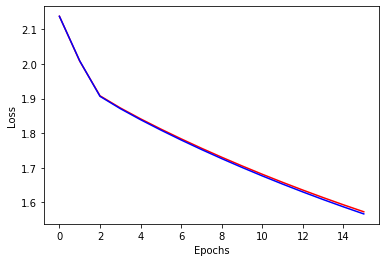

Epoch: 16, error: 1.5534526592665805, train accuracy: 0.7511, test accuracy: 0.7689


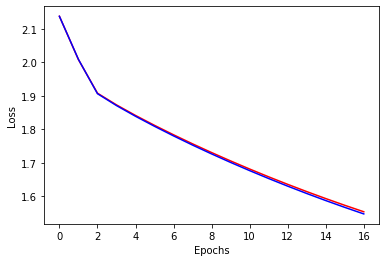

Epoch: 17, error: 1.5348518197812688, train accuracy: 0.7576, test accuracy: 0.7744


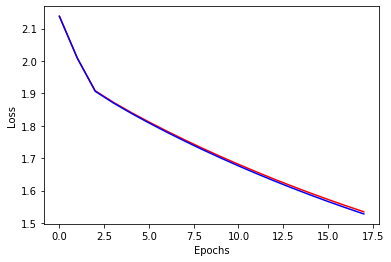

Epoch: 18, error: 1.5169734452383155, train accuracy: 0.7630166666666667, test accuracy: 0.7785


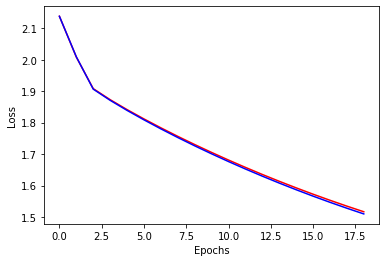

Epoch: 19, error: 1.4997987388110137, train accuracy: 0.7682166666666667, test accuracy: 0.7829


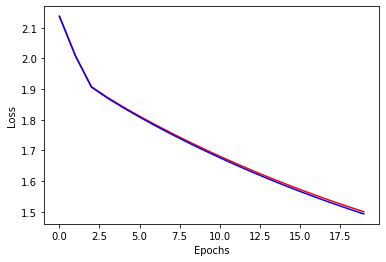

Epoch: 20, error: 1.4833073700579438, train accuracy: 0.7726166666666666, test accuracy: 0.7878


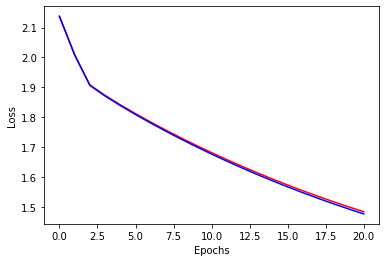

Epoch: 21, error: 1.4674775144508896, train accuracy: 0.7767666666666667, test accuracy: 0.7924


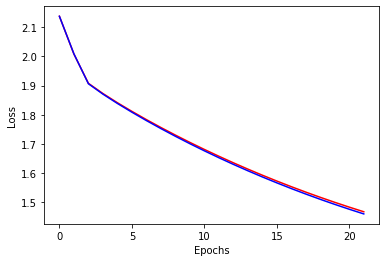

Epoch: 22, error: 1.4522860199857393, train accuracy: 0.7804833333333333, test accuracy: 0.7954


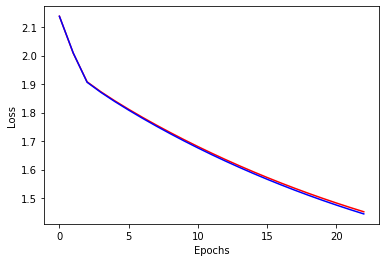

Epoch: 23, error: 1.4377086523354314, train accuracy: 0.7842333333333333, test accuracy: 0.7992


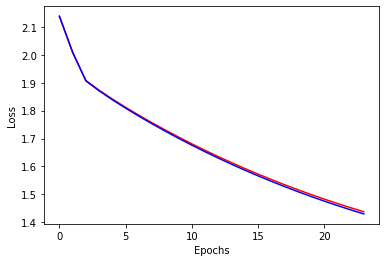

Epoch: 24, error: 1.4237203781832566, train accuracy: 0.788, test accuracy: 0.8018


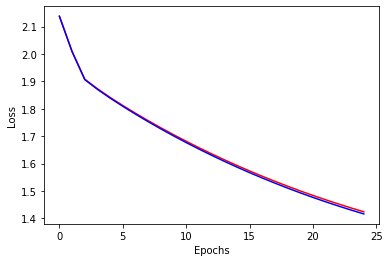

Epoch: 25, error: 1.4102956591552487, train accuracy: 0.7911166666666667, test accuracy: 0.8055


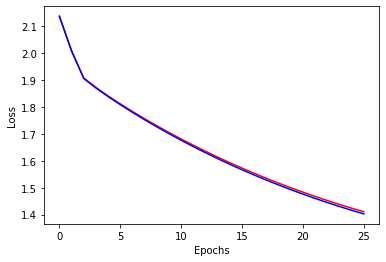

Epoch: 26, error: 1.397408735712225, train accuracy: 0.7936, test accuracy: 0.8075


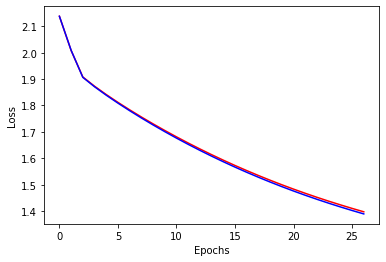

Epoch: 27, error: 1.3850338884854687, train accuracy: 0.7964, test accuracy: 0.8097


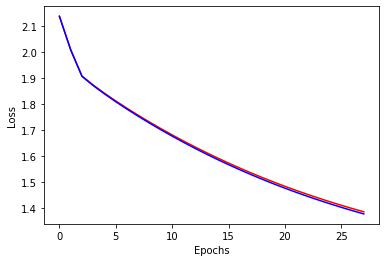

Epoch: 28, error: 1.3731456693550732, train accuracy: 0.79925, test accuracy: 0.8122


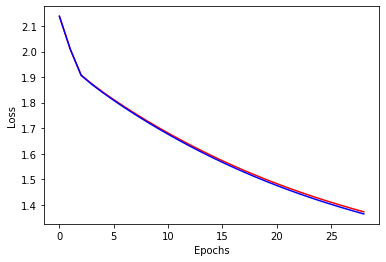

Epoch: 29, error: 1.3617190989110153, train accuracy: 0.8016833333333333, test accuracy: 0.8143


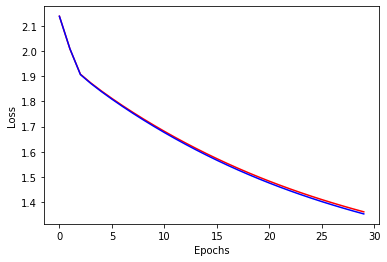

Epoch: 30, error: 1.350729829598932, train accuracy: 0.8039666666666667, test accuracy: 0.8162


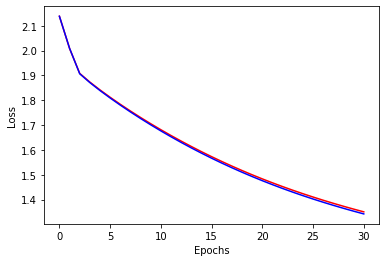

Epoch: 31, error: 1.340154275851304, train accuracy: 0.806, test accuracy: 0.8178


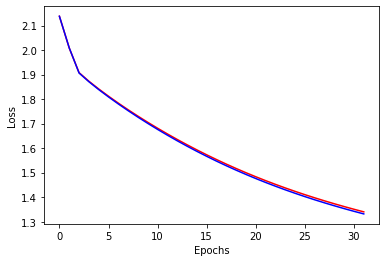

Epoch: 32, error: 1.3299697136561563, train accuracy: 0.8083833333333333, test accuracy: 0.8192


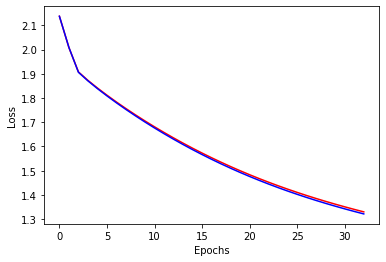

Epoch: 33, error: 1.320154352711838, train accuracy: 0.8101666666666667, test accuracy: 0.8202


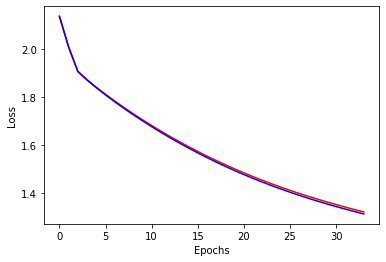

Epoch: 34, error: 1.310687384598432, train accuracy: 0.8122333333333334, test accuracy: 0.8221


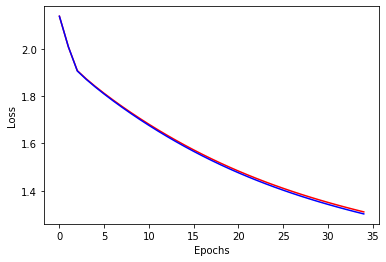

Epoch: 35, error: 1.3015490104355143, train accuracy: 0.8142166666666667, test accuracy: 0.824


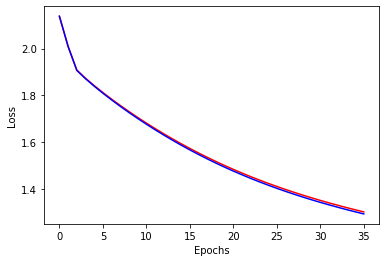

Epoch: 36, error: 1.292720451352396, train accuracy: 0.8159833333333333, test accuracy: 0.8255


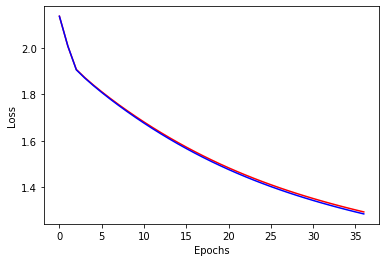

Epoch: 37, error: 1.2841839448516648, train accuracy: 0.8174333333333333, test accuracy: 0.8268


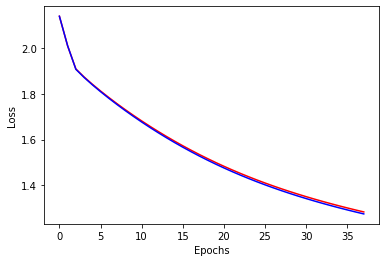

Epoch: 38, error: 1.2759227298406803, train accuracy: 0.8186333333333333, test accuracy: 0.8285


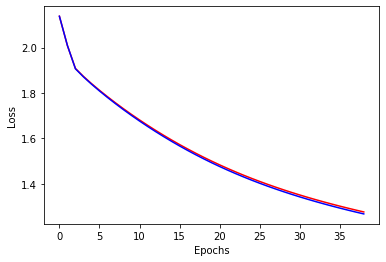

Epoch: 39, error: 1.2679210227768656, train accuracy: 0.8202166666666667, test accuracy: 0.8302


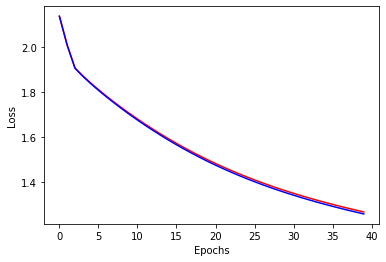

Epoch: 40, error: 1.2601639870426573, train accuracy: 0.8215666666666667, test accuracy: 0.8319


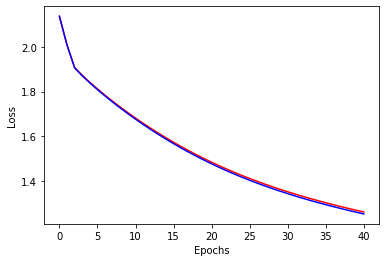

Epoch: 41, error: 1.252637697351239, train accuracy: 0.8230666666666666, test accuracy: 0.8331


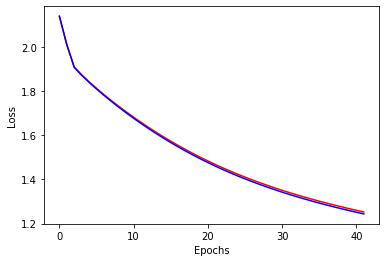

Epoch: 42, error: 1.2453291006932814, train accuracy: 0.8247166666666667, test accuracy: 0.8345


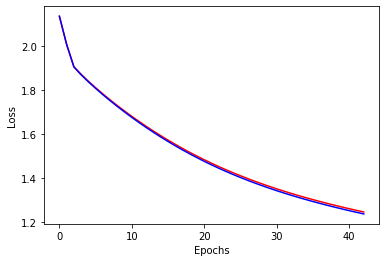

Epoch: 43, error: 1.23822597507308, train accuracy: 0.82625, test accuracy: 0.8361


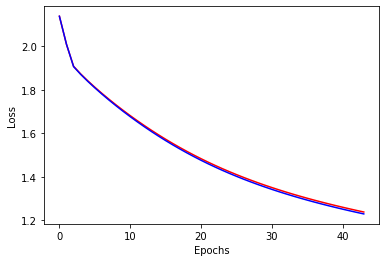

Epoch: 44, error: 1.2313168870512734, train accuracy: 0.82765, test accuracy: 0.8371


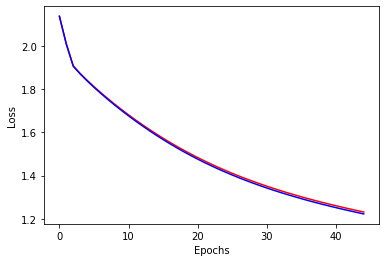

Epoch: 45, error: 1.2245911489106103, train accuracy: 0.82885, test accuracy: 0.8378


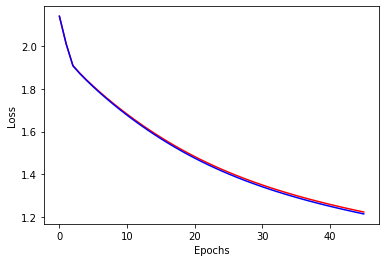

Epoch: 46, error: 1.2180387760893443, train accuracy: 0.8295166666666667, test accuracy: 0.8386


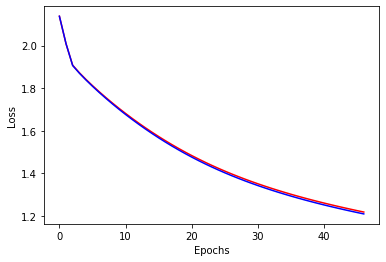

Epoch: 47, error: 1.2116504453814834, train accuracy: 0.8308833333333333, test accuracy: 0.8402


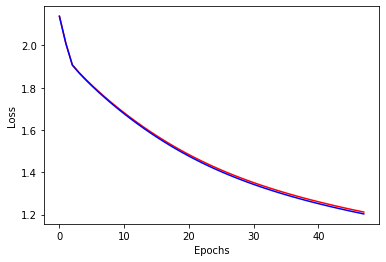

Epoch: 48, error: 1.2054174542815461, train accuracy: 0.8317833333333333, test accuracy: 0.8411


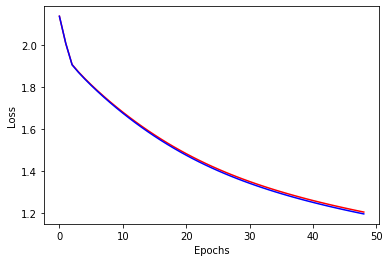

Epoch: 49, error: 1.1993316817508917, train accuracy: 0.83265, test accuracy: 0.841


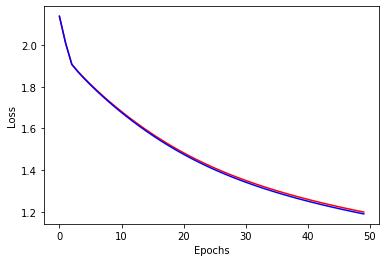

Epoch: 50, error: 1.1933855506003195, train accuracy: 0.8337333333333333, test accuracy: 0.8421


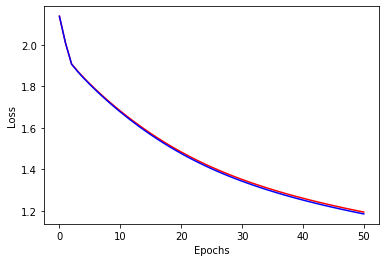

Epoch: 51, error: 1.1875719916168328, train accuracy: 0.8350333333333333, test accuracy: 0.8432


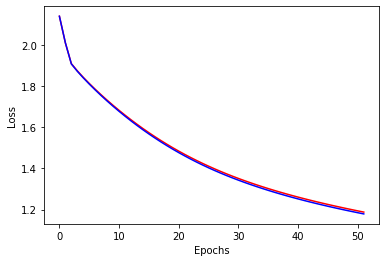

Epoch: 52, error: 1.1818844095089958, train accuracy: 0.8359666666666666, test accuracy: 0.8442


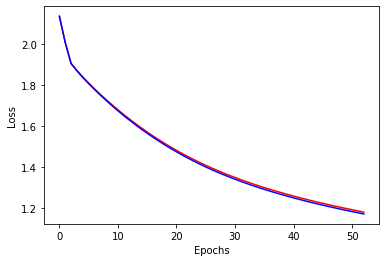

Epoch: 53, error: 1.176316650702892, train accuracy: 0.8370666666666666, test accuracy: 0.845


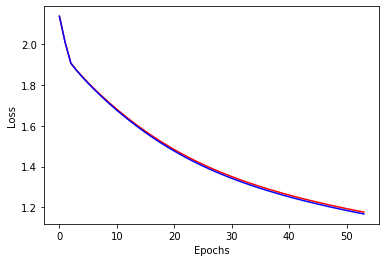

Epoch: 54, error: 1.1708629729876336, train accuracy: 0.8381833333333333, test accuracy: 0.8462


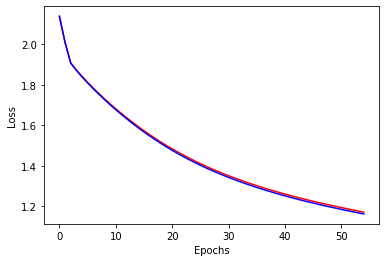

Epoch: 55, error: 1.1655180169839319, train accuracy: 0.8391166666666666, test accuracy: 0.8475


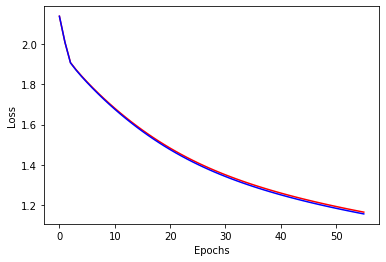

Epoch: 56, error: 1.160276779390153, train accuracy: 0.8399333333333333, test accuracy: 0.848


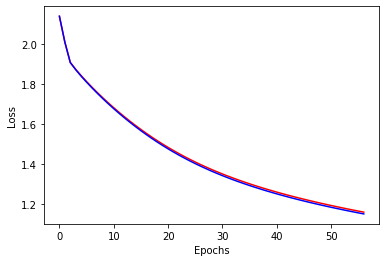

Epoch: 57, error: 1.1551345879462762, train accuracy: 0.8407, test accuracy: 0.8495


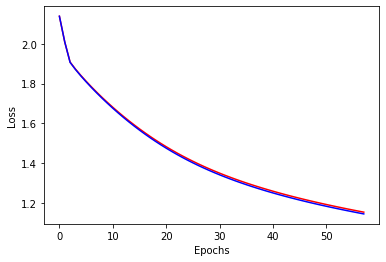

Epoch: 58, error: 1.150087078046358, train accuracy: 0.8415666666666667, test accuracy: 0.8501


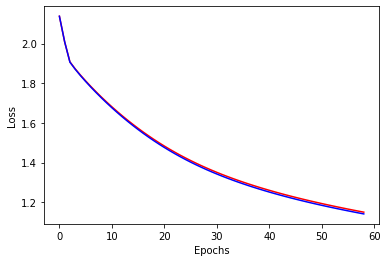

Epoch: 59, error: 1.1451301709235673, train accuracy: 0.8423666666666667, test accuracy: 0.8512


In [21]:
W, b = create_weights(architecture)

W, b, errors_train, acc_train, acc_test = train(architecture, X_train, y_train, X_test, y_test, 10, W, b, f, 0.01, 0.5)

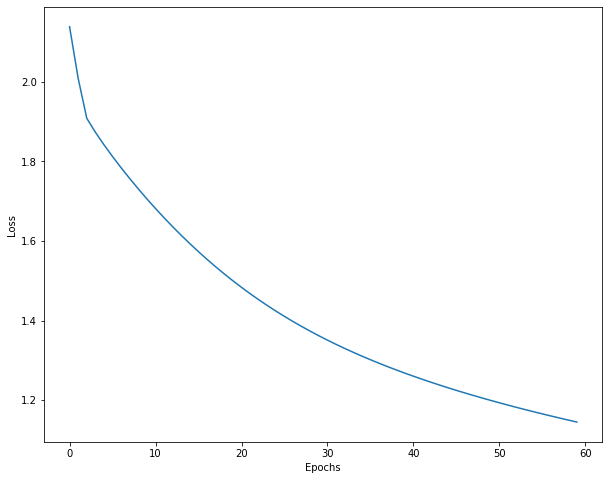

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(errors_train, label='Loss on train DS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

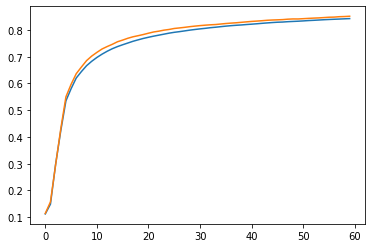

In [23]:
# acc_train, acc_test
plt.plot(acc_train, label='Acc train')
plt.plot(acc_test, label='Acc test')

# Test model

In [24]:
print(f'Accuracy on train set: {accuracy(X_train, y_train, W, b, f)}')
print(f'Accuracy on test set: {accuracy(X_test, y_test, W, b, f)}')

Accuracy on train set: 0.8423666666666667
Accuracy on test set: 0.8512


In [183]:
train_data = pd.read_csv('./data/mnist_train.csv', header=None).to_numpy()
np.random.shuffle(train_data)
y_train = np.vstack(train_data[:, 0]).T
X_train = train_data[:, 1:].T
X_train = scale_values(X_train)
X_train_trn = X_train[:, 0:50000]
X_train_tst = X_train[:, 50000:]
y_train_trn = np.hstack(np.array(y_train)[:, 0:50000])
y_train_tst = np.hstack(np.array(y_train)[:, 50000:])

print(f'X train set size: {X_train_trn.shape}')
print(f'X  test set size: {X_train_tst.shape}')
print(f'y train set size: {y_train_trn.shape}')
print(f'y  test set size: {y_train_tst.shape}')

X train set size: (784, 50000)
X  test set size: (784, 10000)
y train set size: (50000,)
y  test set size: (10000,)


In [184]:
def train_holdout(architecture: List[int], X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, num_classes, W: List[np.array], b:List[np.array], f:List[Callable], _lambda: float, alpha: float, n_epochs:int=20) -> Tuple[List[np.array], List[np.array], List[float], List[float], List[float]]:
    epoch = 0
    print(f'\nTRAINING NEURAL NETWORK: 1 hidden layer w/ {architecture[1]} neurons, {n_epochs} epochs:')
    p = X_train.shape[1]
    while True:
        epoch += 1
        # actualizare ponderi si biases W, b pentru fiecare pereche de date din setul de instruire *_test
        W, b = backpropagation(architecture, X_train, y_train, W, b, num_classes, _lambda, alpha)
        error_test = J(X_test, y_test, W, b, f, num_classes, _lambda)
        
        train_acc = accuracy(X_train, y_train, W, b, f)
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, W, b, f)
        acc_test.append(test_acc)

        print(f'Epoch: {epoch}, test error: {error_test}, train accuracy: {train_acc}, test accuracy: {test_acc}')
        if epoch == n_epochs:
            break
    return W, b, error_test, acc_train, acc_test

In [185]:
# hidden layer sizes candidates
hidden_layer_sizes = [10, 50, 100, 200, 300]
errors = []
for hls in hidden_layer_sizes:
    custom_arch = [architecture[0], hls, architecture[2]]
    W, b = create_weights(custom_arch)
    _, _, error, _, _ = train_holdout(custom_arch, X_train_trn, y_train_trn, X_train_tst, y_train_tst, 10, W, b, f, 0.01, 0.5)
    errors.append(error)


TRAINING NEURAL NETWORK: 1 hidden layer w/ 10 neurons, 20 epochs:
Epoch: 1, test error: 1.1672703773425026, train accuracy: 0.07442, test accuracy: 0.0741
Epoch: 2, test error: 1.1458950698162238, train accuracy: 0.10744, test accuracy: 0.1086
Epoch: 3, test error: 1.1288296181232256, train accuracy: 0.1519, test accuracy: 0.1525
Epoch: 4, test error: 1.1142304971663513, train accuracy: 0.21906, test accuracy: 0.2197
Epoch: 5, test error: 1.1013374521468735, train accuracy: 0.29036, test accuracy: 0.2886
Epoch: 6, test error: 1.0897089584612456, train accuracy: 0.34708, test accuracy: 0.3441
Epoch: 7, test error: 1.0790491116442384, train accuracy: 0.38422, test accuracy: 0.3814
Epoch: 8, test error: 1.0691552511377236, train accuracy: 0.41008, test accuracy: 0.4078
Epoch: 9, test error: 1.0598879197226316, train accuracy: 0.43238, test accuracy: 0.4307
Epoch: 10, test error: 1.05114947660964, train accuracy: 0.44982, test accuracy: 0.4482
Epoch: 11, test error: 1.0428695973006616, tr

In [194]:
idx_error_min = np.array(errors).argmin()
print(f'Minimum error: {errors[idx_error_min]}, architecture: {hidden_layer_sizes[idx_error_min]} neurons on hidden layer')

Minimum error: 0.9829004591010778, architecture: 10 neurons on hidden layer


Epoch: 0, error: 1.2021976819136464, train accuracy: 0.07973333333333334, test accuracy: 0.0754
Epoch: 1, error: 1.1609098213516245, train accuracy: 0.1236, test accuracy: 0.1167


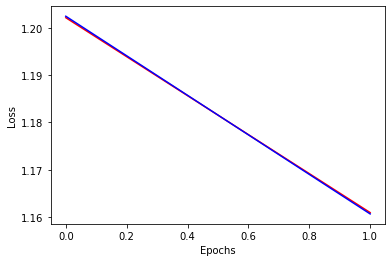

Epoch: 2, error: 1.1379102576231388, train accuracy: 0.13996666666666666, test accuracy: 0.1354


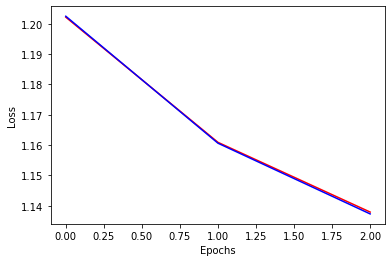

Epoch: 3, error: 1.120915705902446, train accuracy: 0.16236666666666666, test accuracy: 0.1559


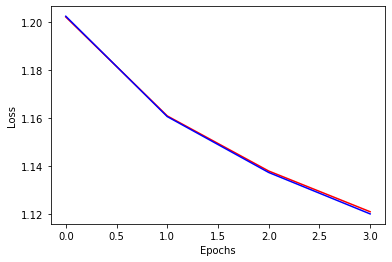

Epoch: 4, error: 1.1067133737690316, train accuracy: 0.22045, test accuracy: 0.2124


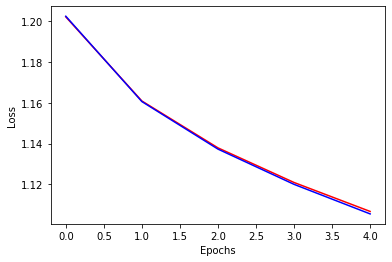

Epoch: 5, error: 1.0940308720211744, train accuracy: 0.27048333333333335, test accuracy: 0.2654


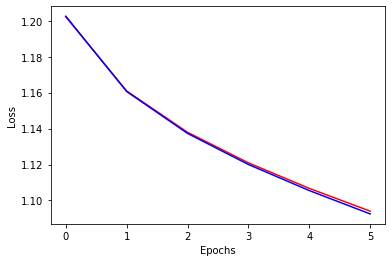

Epoch: 6, error: 1.0823028831744406, train accuracy: 0.3137333333333333, test accuracy: 0.3116


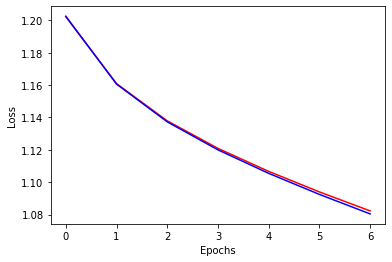

Epoch: 7, error: 1.0712797933546299, train accuracy: 0.35265, test accuracy: 0.3544


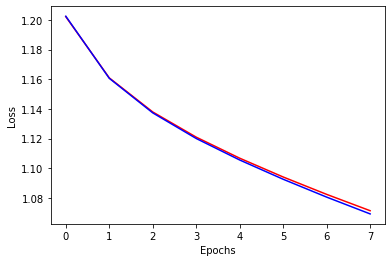

Epoch: 8, error: 1.0608570040133638, train accuracy: 0.38453333333333334, test accuracy: 0.3934


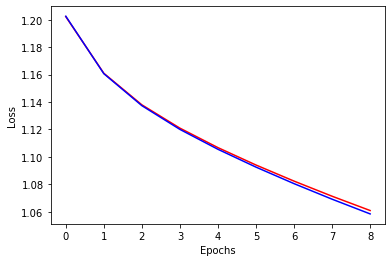

Epoch: 9, error: 1.0509896084993224, train accuracy: 0.4185, test accuracy: 0.4336


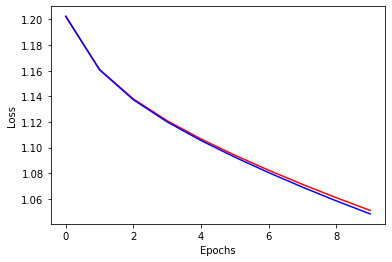

Epoch: 10, error: 1.041650163299278, train accuracy: 0.44765, test accuracy: 0.4657


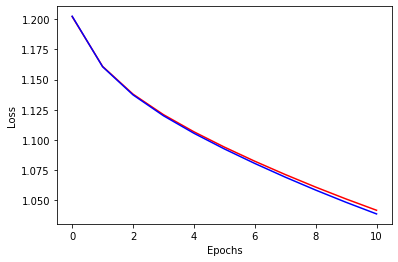

Epoch: 11, error: 1.0328104323836502, train accuracy: 0.4719, test accuracy: 0.4902


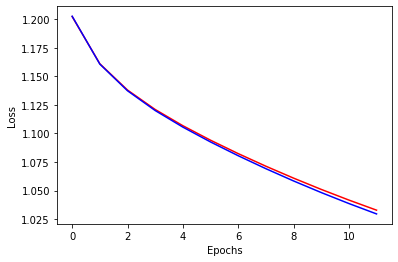

Epoch: 12, error: 1.0244362491534105, train accuracy: 0.4903166666666667, test accuracy: 0.5109


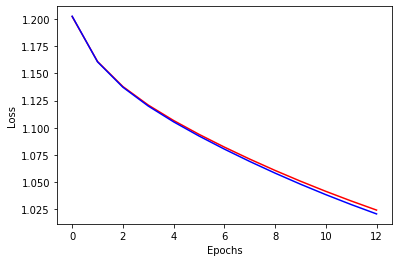

Epoch: 13, error: 1.0164887429896843, train accuracy: 0.5059333333333333, test accuracy: 0.5247


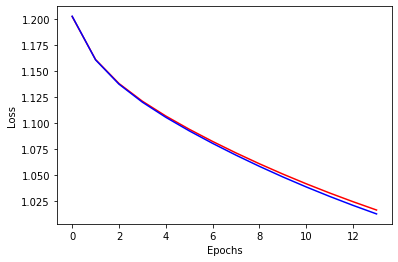

Epoch: 14, error: 1.008927642000065, train accuracy: 0.5202833333333333, test accuracy: 0.5365


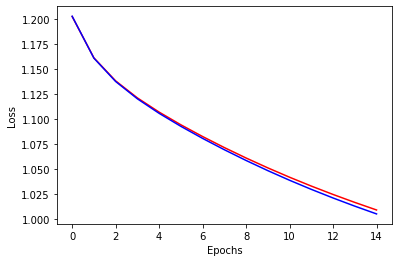

Epoch: 15, error: 1.0017143185446529, train accuracy: 0.5327833333333334, test accuracy: 0.5471


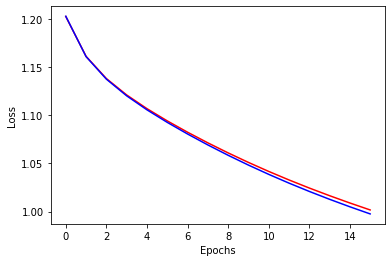

Epoch: 16, error: 0.994813748951247, train accuracy: 0.5436, test accuracy: 0.558


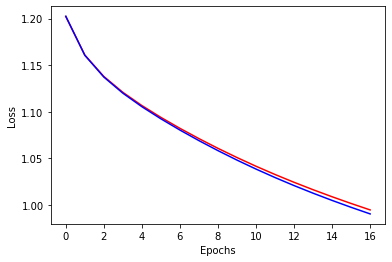

Epoch: 17, error: 0.988195406538561, train accuracy: 0.5523333333333333, test accuracy: 0.5684


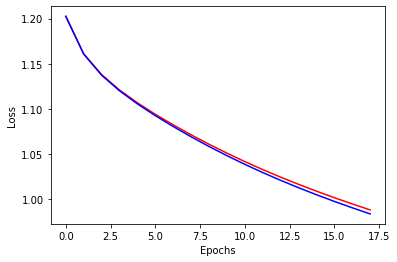

Epoch: 18, error: 0.9818333983382365, train accuracy: 0.5615166666666667, test accuracy: 0.5758


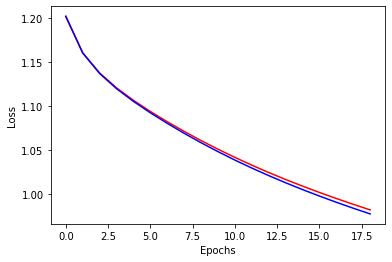

Epoch: 19, error: 0.9757061585470629, train accuracy: 0.5690333333333333, test accuracy: 0.5842


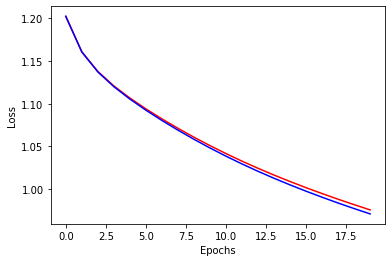

Epoch: 20, error: 0.969795927143841, train accuracy: 0.5760333333333333, test accuracy: 0.5904


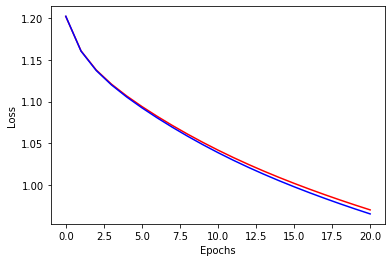

Epoch: 21, error: 0.9640881583905674, train accuracy: 0.5826, test accuracy: 0.5957


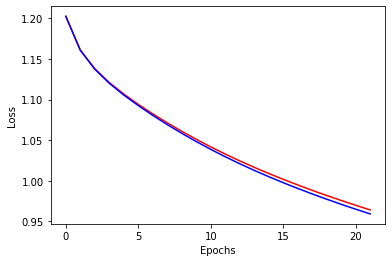

Epoch: 22, error: 0.9585709427442487, train accuracy: 0.5881666666666666, test accuracy: 0.6016


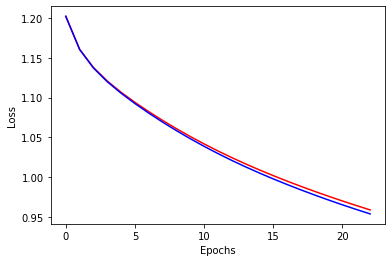

Epoch: 23, error: 0.9532344853235546, train accuracy: 0.5937, test accuracy: 0.6062


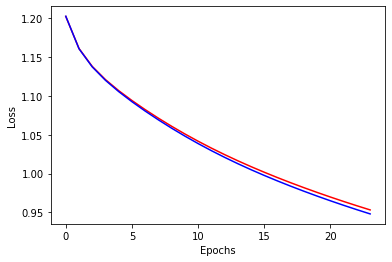

Epoch: 24, error: 0.9480706586907389, train accuracy: 0.5986833333333333, test accuracy: 0.6087


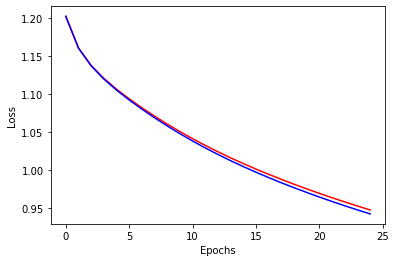

Epoch: 25, error: 0.9430726325558207, train accuracy: 0.6039333333333333, test accuracy: 0.6138


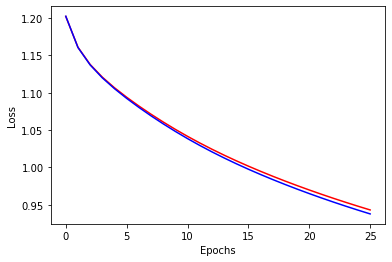

Epoch: 26, error: 0.938234574740929, train accuracy: 0.6081833333333333, test accuracy: 0.6172


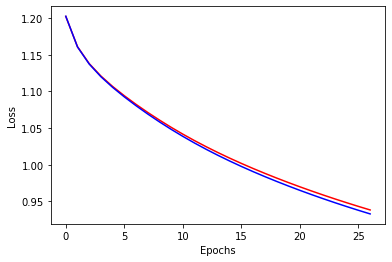

Epoch: 27, error: 0.9335514139789973, train accuracy: 0.6126833333333334, test accuracy: 0.6217


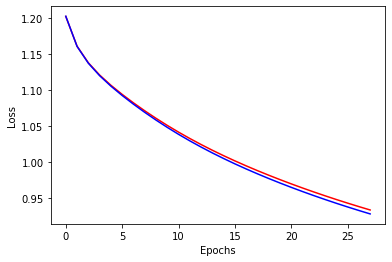

Epoch: 28, error: 0.9290186541334038, train accuracy: 0.6166833333333334, test accuracy: 0.626


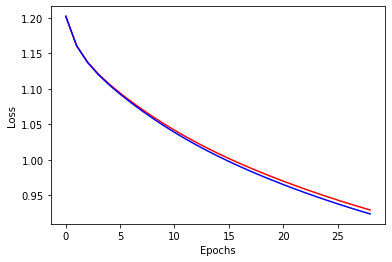

Epoch: 29, error: 0.9246322299818994, train accuracy: 0.6202166666666666, test accuracy: 0.6306


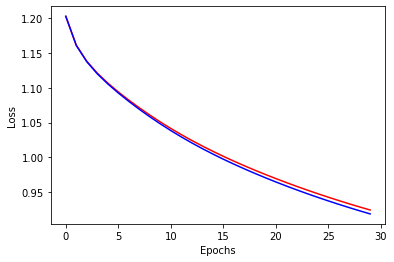

Epoch: 30, error: 0.9203883959828024, train accuracy: 0.6242, test accuracy: 0.6364


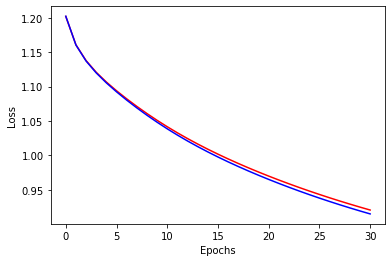

Epoch: 31, error: 0.9162836409262465, train accuracy: 0.62825, test accuracy: 0.64


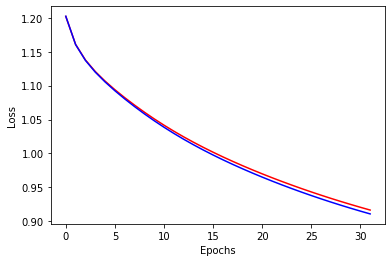

Epoch: 32, error: 0.9123146227914709, train accuracy: 0.6320166666666667, test accuracy: 0.6441


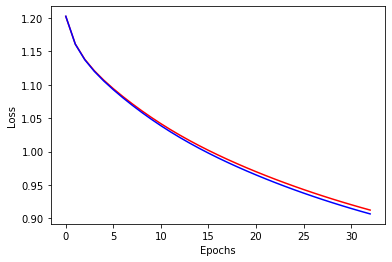

Epoch: 33, error: 0.9084781193581829, train accuracy: 0.6353666666666666, test accuracy: 0.647


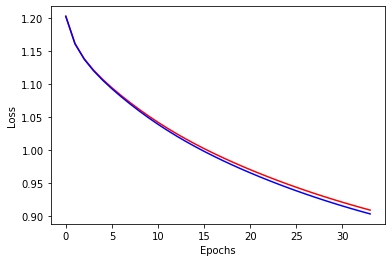

Epoch: 34, error: 0.9047709911211329, train accuracy: 0.6390833333333333, test accuracy: 0.6507


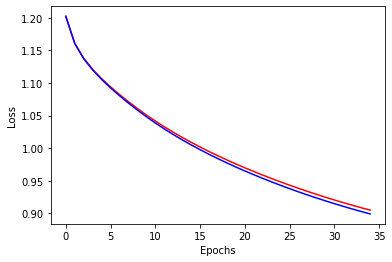

Epoch: 35, error: 0.9011901538440829, train accuracy: 0.64245, test accuracy: 0.653


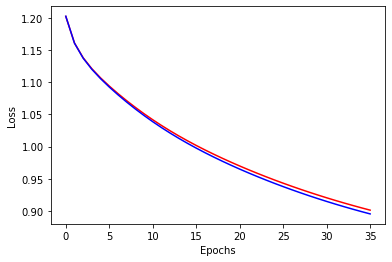

Epoch: 36, error: 0.897732558693805, train accuracy: 0.6455166666666666, test accuracy: 0.6557


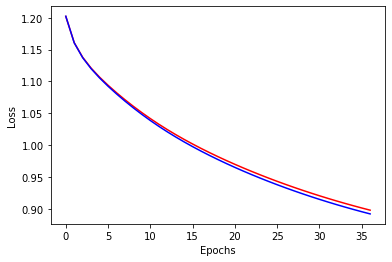

Epoch: 37, error: 0.8943951783526766, train accuracy: 0.6489666666666667, test accuracy: 0.658


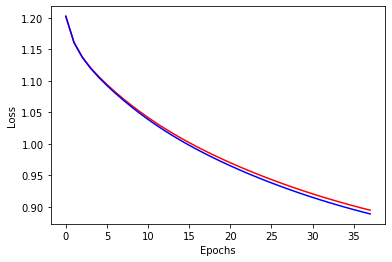

Epoch: 38, error: 0.8911749978532254, train accuracy: 0.6517166666666667, test accuracy: 0.6608


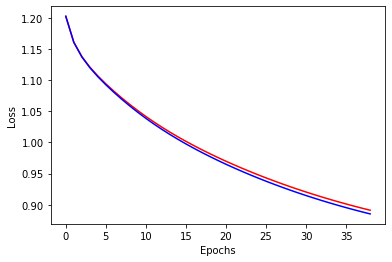

Epoch: 39, error: 0.8880690091376847, train accuracy: 0.6545, test accuracy: 0.6629


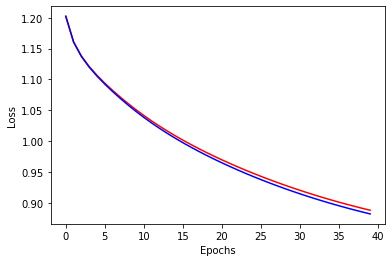

Epoch: 40, error: 0.8850742085423733, train accuracy: 0.6570333333333334, test accuracy: 0.6655


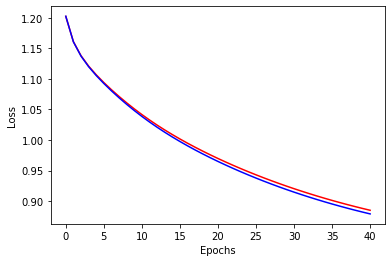

Epoch: 41, error: 0.8821875965573837, train accuracy: 0.6594166666666667, test accuracy: 0.6679


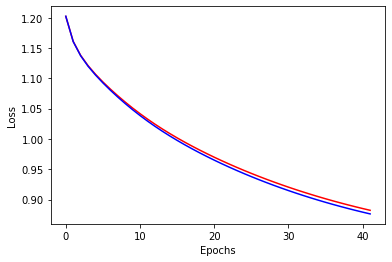

Epoch: 42, error: 0.87940617932933, train accuracy: 0.6617666666666666, test accuracy: 0.6701


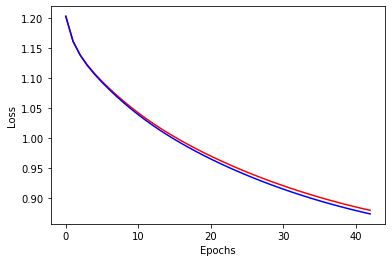

Epoch: 43, error: 0.8767269714678054, train accuracy: 0.6640833333333334, test accuracy: 0.672


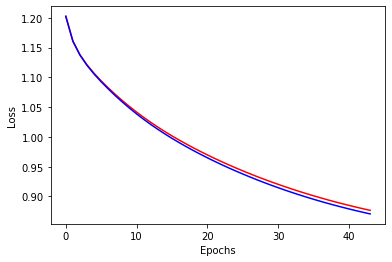

Epoch: 44, error: 0.8741469997914125, train accuracy: 0.66645, test accuracy: 0.6743


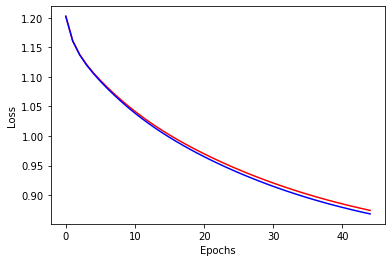

Epoch: 45, error: 0.8716633077113916, train accuracy: 0.6692666666666667, test accuracy: 0.677


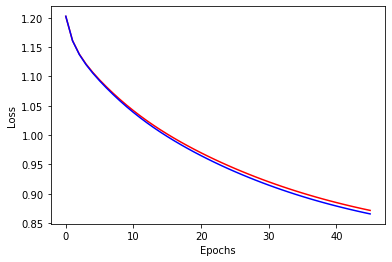

Epoch: 46, error: 0.8692729600031941, train accuracy: 0.6715833333333333, test accuracy: 0.6786


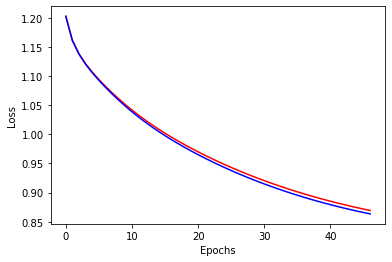

Epoch: 47, error: 0.866973047761114, train accuracy: 0.6735333333333333, test accuracy: 0.6804


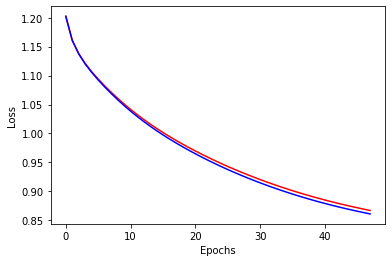

Epoch: 48, error: 0.8647606933697564, train accuracy: 0.6757333333333333, test accuracy: 0.683


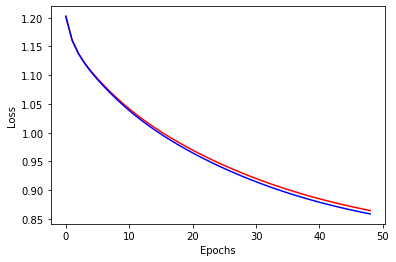

Epoch: 49, error: 0.8626330553597803, train accuracy: 0.6778166666666666, test accuracy: 0.6851


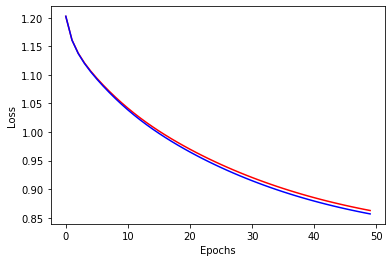

Epoch: 50, error: 0.8605873330446, train accuracy: 0.6794666666666667, test accuracy: 0.6859


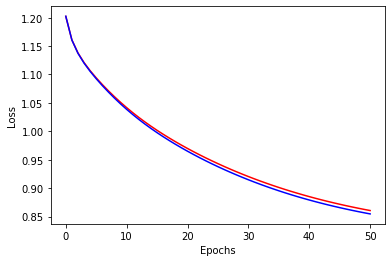

Epoch: 51, error: 0.8586207708601495, train accuracy: 0.6814, test accuracy: 0.6878


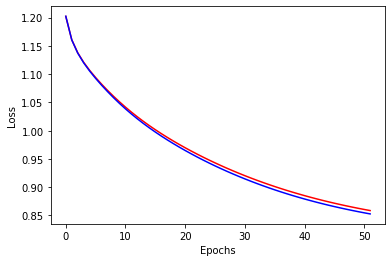

Epoch: 52, error: 0.8567306623516943, train accuracy: 0.68335, test accuracy: 0.6912


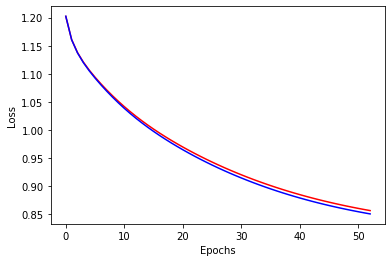

Epoch: 53, error: 0.854914353770319, train accuracy: 0.6852, test accuracy: 0.6922


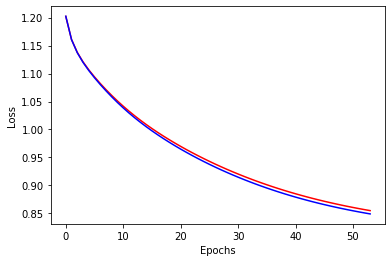

Epoch: 54, error: 0.8531692472574303, train accuracy: 0.6870833333333334, test accuracy: 0.6945


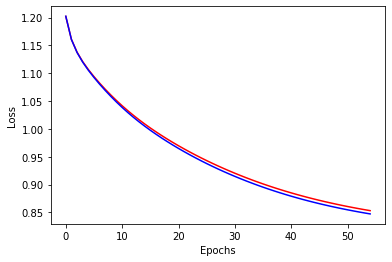

Epoch: 55, error: 0.8514928036085635, train accuracy: 0.6891666666666667, test accuracy: 0.6962


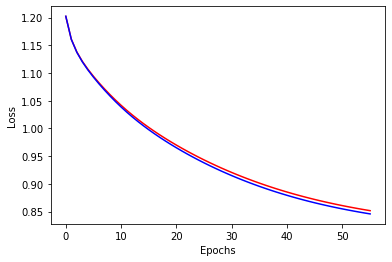

Epoch: 56, error: 0.849882544618296, train accuracy: 0.6911166666666667, test accuracy: 0.6979


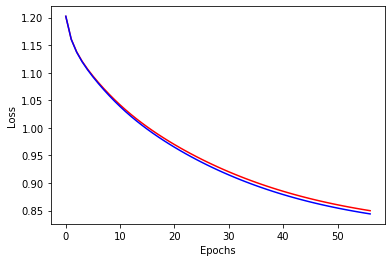

Epoch: 57, error: 0.8483360550163408, train accuracy: 0.6931, test accuracy: 0.7004


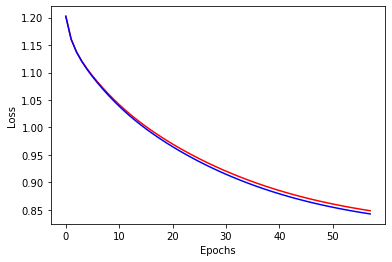

Epoch: 58, error: 0.8468509840112183, train accuracy: 0.69535, test accuracy: 0.703


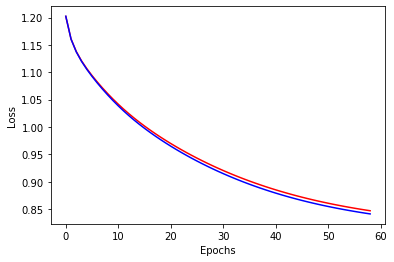

Epoch: 59, error: 0.8454250464625062, train accuracy: 0.6974166666666667, test accuracy: 0.705


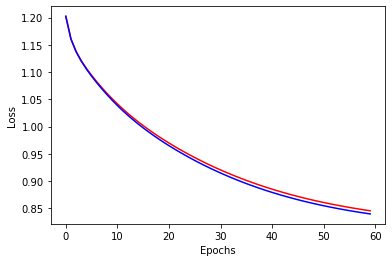

Epoch: 60, error: 0.8440560237058075, train accuracy: 0.69895, test accuracy: 0.7061


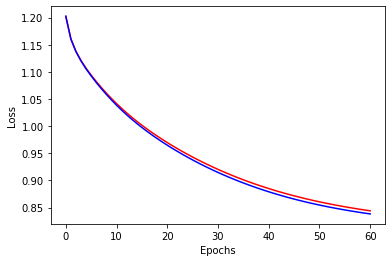

Epoch: 61, error: 0.8427417640565057, train accuracy: 0.7005166666666667, test accuracy: 0.708


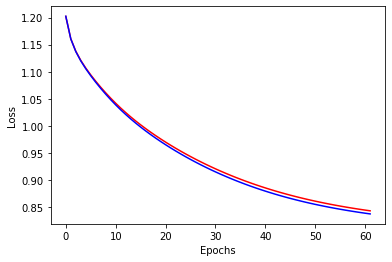

Epoch: 62, error: 0.8414801830192635, train accuracy: 0.7019833333333333, test accuracy: 0.7101


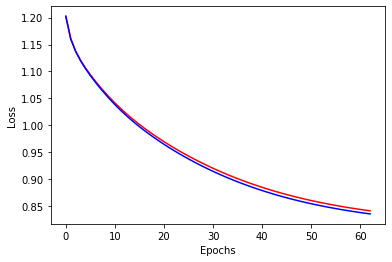

Epoch: 63, error: 0.8402692632303387, train accuracy: 0.7036, test accuracy: 0.7118


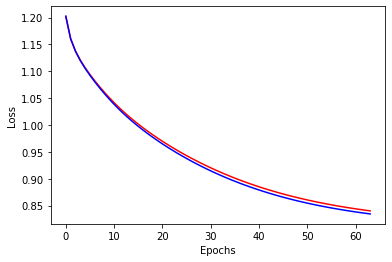

Epoch: 64, error: 0.8391070541592677, train accuracy: 0.70525, test accuracy: 0.7131


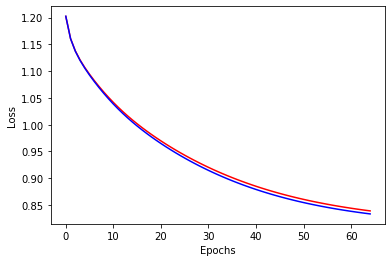

Epoch: 65, error: 0.8379916715954815, train accuracy: 0.7070166666666666, test accuracy: 0.7149


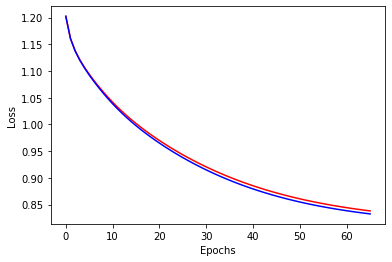

Epoch: 66, error: 0.8369212969440972, train accuracy: 0.7088, test accuracy: 0.7162


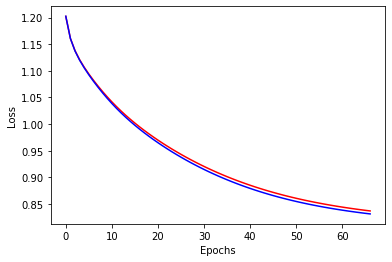

Epoch: 67, error: 0.8358941763536234, train accuracy: 0.7104666666666667, test accuracy: 0.7185


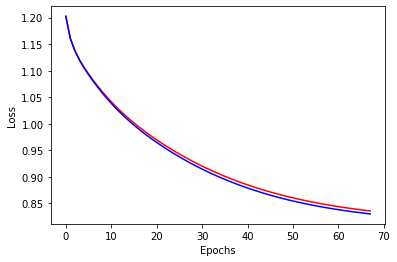

Epoch: 68, error: 0.8349086196966564, train accuracy: 0.7121166666666666, test accuracy: 0.7201


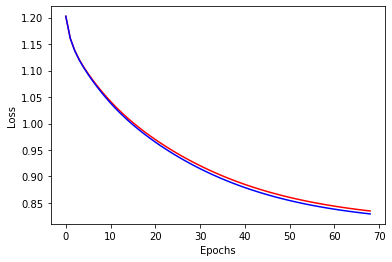

Epoch: 69, error: 0.8339629994229856, train accuracy: 0.7139666666666666, test accuracy: 0.7216


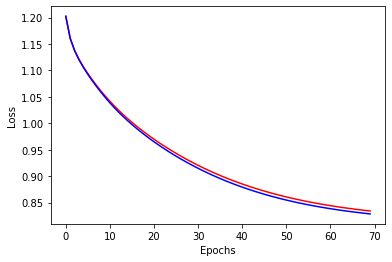

Epoch: 70, error: 0.8330557493028468, train accuracy: 0.7155333333333334, test accuracy: 0.7232


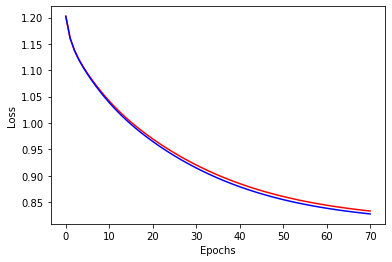

Epoch: 71, error: 0.8321853630764791, train accuracy: 0.71725, test accuracy: 0.7237


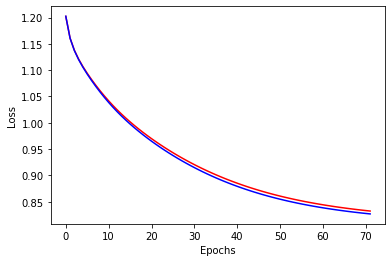

Epoch: 72, error: 0.8313503930246304, train accuracy: 0.7187166666666667, test accuracy: 0.7249


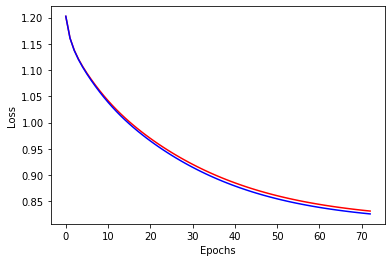

Epoch: 73, error: 0.8305494484732706, train accuracy: 0.7202166666666666, test accuracy: 0.7264


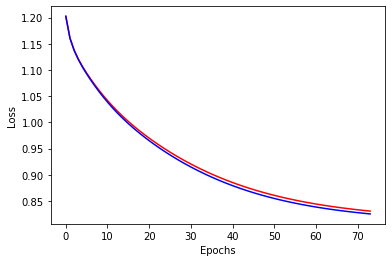

Epoch: 74, error: 0.829781194244503, train accuracy: 0.7216833333333333, test accuracy: 0.7282


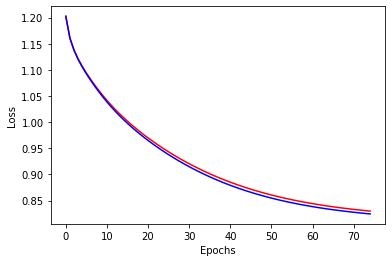

Epoch: 75, error: 0.8290443490645308, train accuracy: 0.7230833333333333, test accuracy: 0.7297


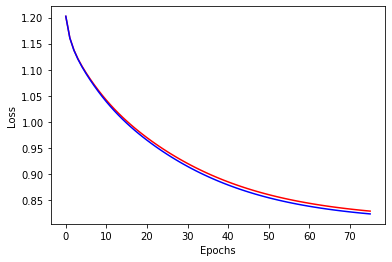

Epoch: 76, error: 0.8283376839385126, train accuracy: 0.7249, test accuracy: 0.7314


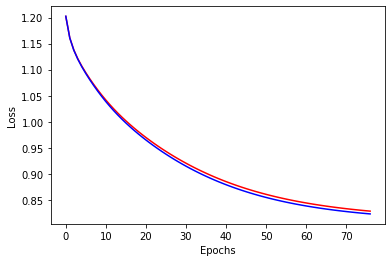

Epoch: 77, error: 0.827660020501246, train accuracy: 0.7263, test accuracy: 0.7333


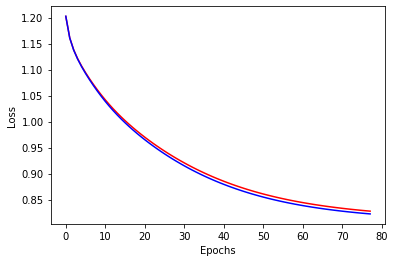

Epoch: 78, error: 0.8270102293518204, train accuracy: 0.728, test accuracy: 0.7344


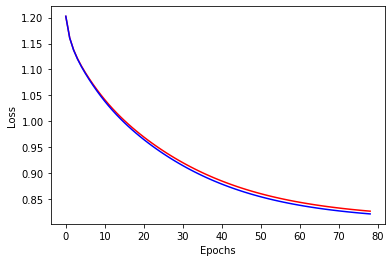

Epoch: 79, error: 0.826387228379682, train accuracy: 0.7297666666666667, test accuracy: 0.7359


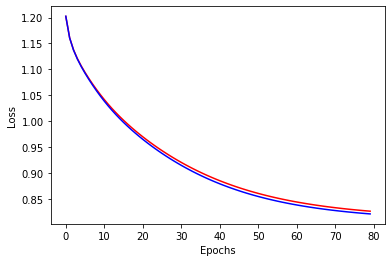

Epoch: 80, error: 0.8257899810889185, train accuracy: 0.7313666666666667, test accuracy: 0.7368


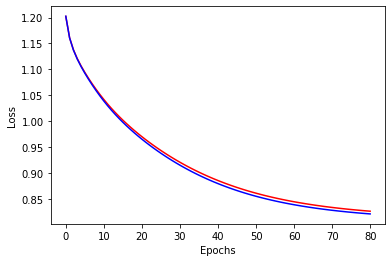

Epoch: 81, error: 0.8252174949270266, train accuracy: 0.73255, test accuracy: 0.7385


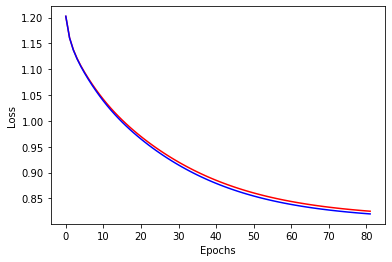

Epoch: 82, error: 0.824668819623899, train accuracy: 0.73385, test accuracy: 0.7398


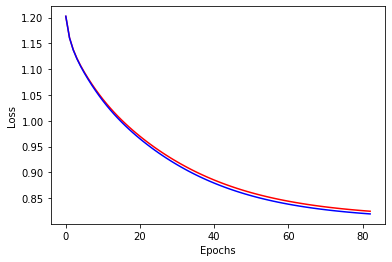

Epoch: 83, error: 0.8241430455463212, train accuracy: 0.7350166666666667, test accuracy: 0.7411


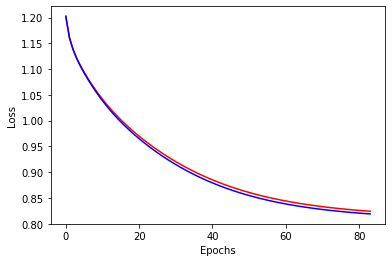

Epoch: 84, error: 0.8236393020728088, train accuracy: 0.7363666666666666, test accuracy: 0.7423


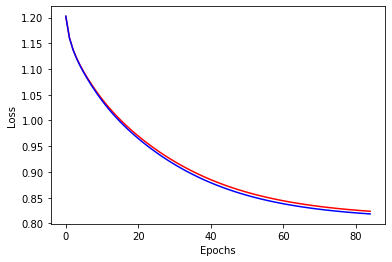

Epoch: 85, error: 0.8231567559932103, train accuracy: 0.7374833333333334, test accuracy: 0.7441


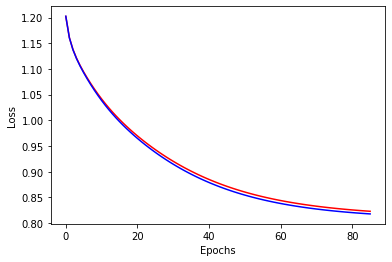

Epoch: 86, error: 0.8226946099370968, train accuracy: 0.7387833333333333, test accuracy: 0.7449


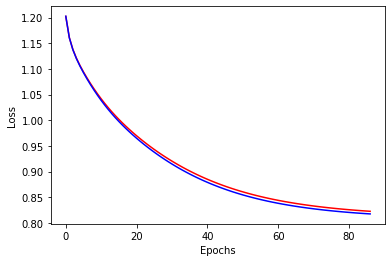

Epoch: 87, error: 0.8222521008345585, train accuracy: 0.74045, test accuracy: 0.7463


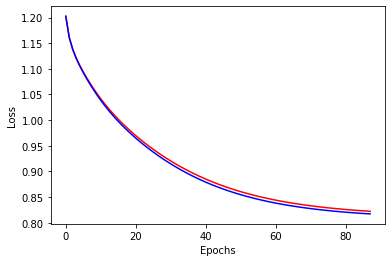

Epoch: 88, error: 0.8218284984126454, train accuracy: 0.7419333333333333, test accuracy: 0.747


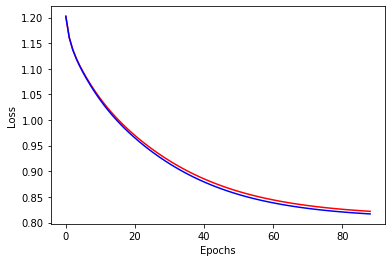

Epoch: 89, error: 0.8214231037303037, train accuracy: 0.7432666666666666, test accuracy: 0.7486


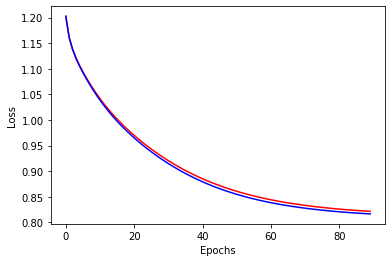

Epoch: 90, error: 0.8210352477542795, train accuracy: 0.7447, test accuracy: 0.7497


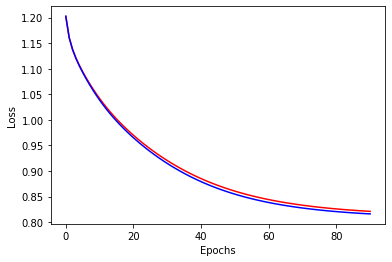

Epoch: 91, error: 0.8206642899780876, train accuracy: 0.7459666666666667, test accuracy: 0.7509


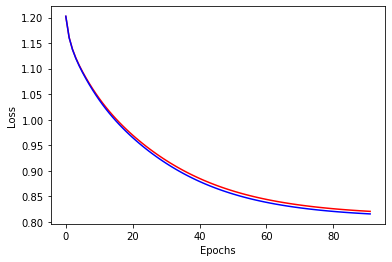

Epoch: 92, error: 0.8203096170857723, train accuracy: 0.7473333333333333, test accuracy: 0.7522


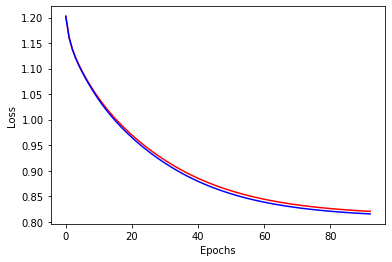

Epoch: 93, error: 0.8199706416618397, train accuracy: 0.7485, test accuracy: 0.754


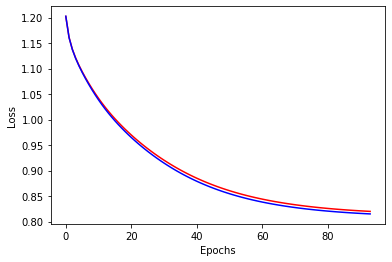

Epoch: 94, error: 0.8196468009483766, train accuracy: 0.7493333333333333, test accuracy: 0.7553


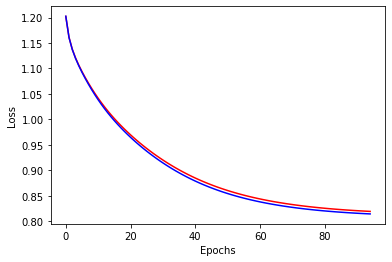

Epoch: 95, error: 0.8193375556500595, train accuracy: 0.7507, test accuracy: 0.7571


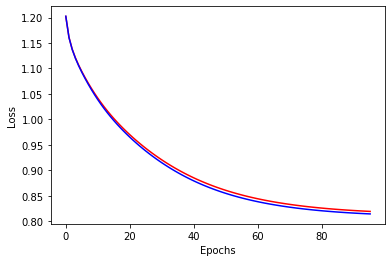

Epoch: 96, error: 0.8190423887874301, train accuracy: 0.7522833333333333, test accuracy: 0.7575


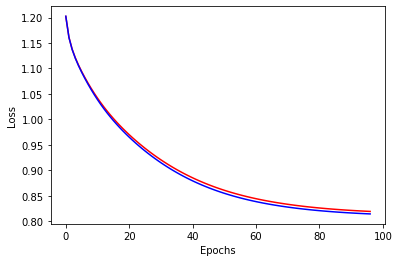

Epoch: 97, error: 0.8187608045985237, train accuracy: 0.7534833333333333, test accuracy: 0.7586


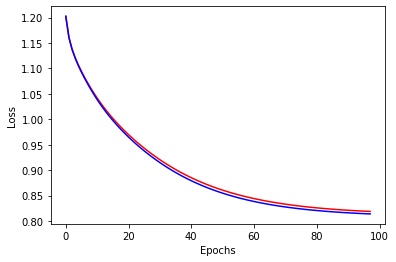

Epoch: 98, error: 0.818492327488664, train accuracy: 0.7545833333333334, test accuracy: 0.7598


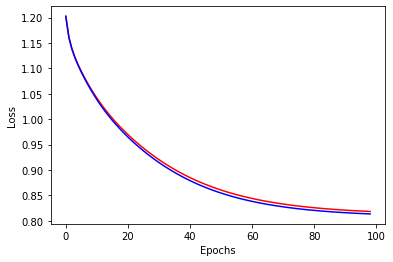

Epoch: 99, error: 0.8182365010279887, train accuracy: 0.7560333333333333, test accuracy: 0.7609


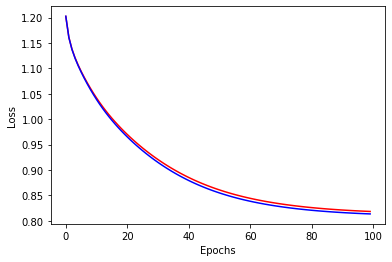

Epoch: 100, error: 0.8179928869960482, train accuracy: 0.7572, test accuracy: 0.762


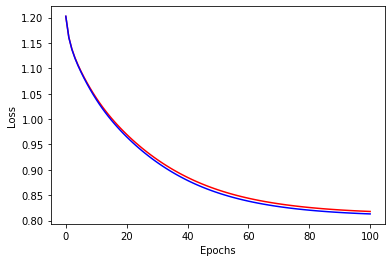

Epoch: 101, error: 0.8177610644726117, train accuracy: 0.7584666666666666, test accuracy: 0.7633


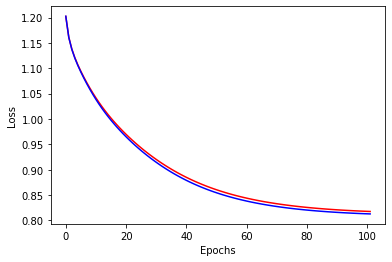

Epoch: 102, error: 0.8175406289736535, train accuracy: 0.7596666666666667, test accuracy: 0.7646


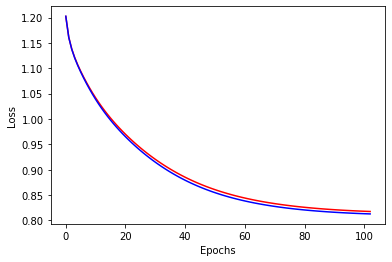

Epoch: 103, error: 0.8173311916313309, train accuracy: 0.76075, test accuracy: 0.765


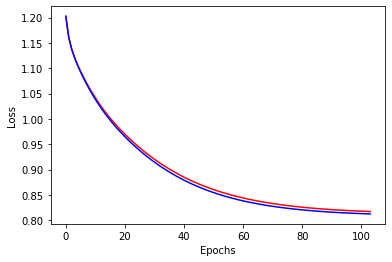

Epoch: 104, error: 0.8171323784166462, train accuracy: 0.7617833333333334, test accuracy: 0.7662


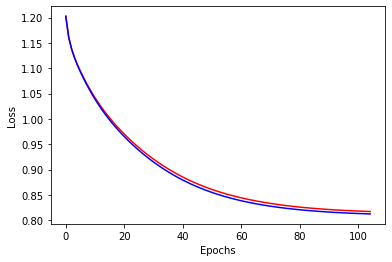

Epoch: 105, error: 0.8169438294033828, train accuracy: 0.7629833333333333, test accuracy: 0.767


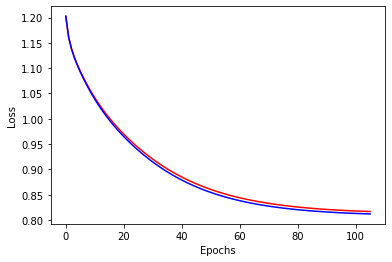

Epoch: 106, error: 0.8167651980718241, train accuracy: 0.7641333333333333, test accuracy: 0.7691


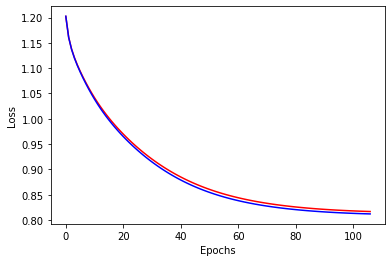

Epoch: 107, error: 0.8165961506507013, train accuracy: 0.7651833333333333, test accuracy: 0.7702


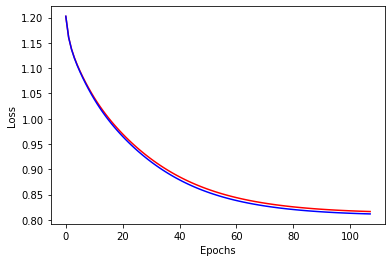

Epoch: 108, error: 0.8164363654957869, train accuracy: 0.7661, test accuracy: 0.7712


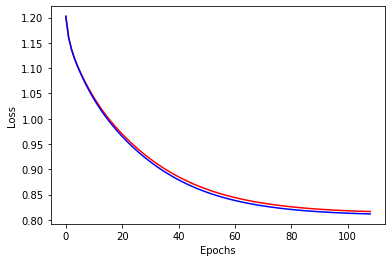

Epoch: 109, error: 0.8162855325035082, train accuracy: 0.7673, test accuracy: 0.772


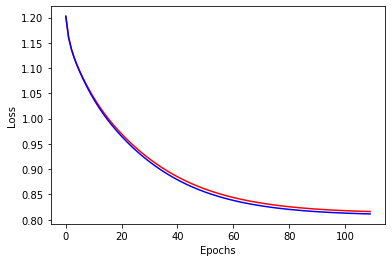

Epoch: 110, error: 0.816143352557964, train accuracy: 0.7684333333333333, test accuracy: 0.773


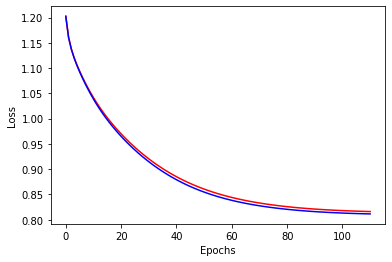

Epoch: 111, error: 0.8160095370097198, train accuracy: 0.76975, test accuracy: 0.7742


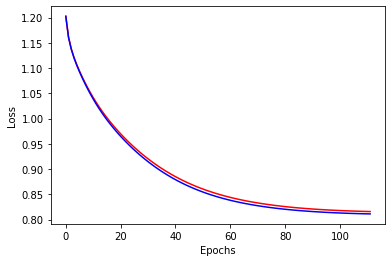

Epoch: 112, error: 0.8158838071847847, train accuracy: 0.7705833333333333, test accuracy: 0.7748


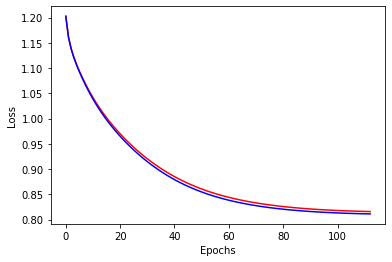

Epoch: 113, error: 0.8157658939221835, train accuracy: 0.7716, test accuracy: 0.7763


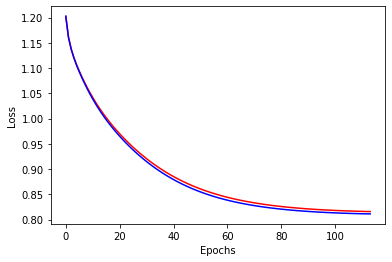

Epoch: 114, error: 0.815655537138591, train accuracy: 0.7725833333333333, test accuracy: 0.7773


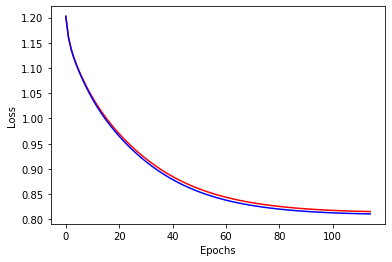

Epoch: 115, error: 0.8155524854185212, train accuracy: 0.7735833333333333, test accuracy: 0.7783


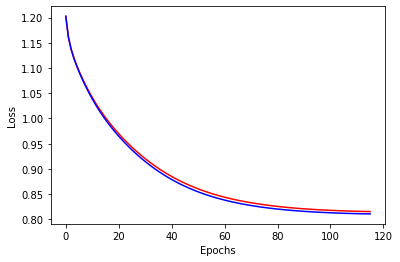

Epoch: 116, error: 0.8154564956286194, train accuracy: 0.7746666666666666, test accuracy: 0.7796


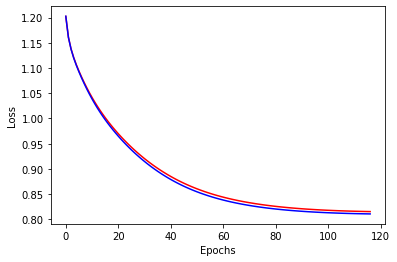

Epoch: 117, error: 0.8153673325546547, train accuracy: 0.7755166666666666, test accuracy: 0.7799


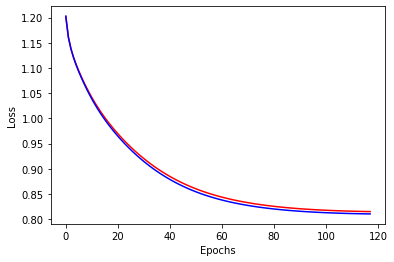

Epoch: 118, error: 0.8152847685598666, train accuracy: 0.77645, test accuracy: 0.7811


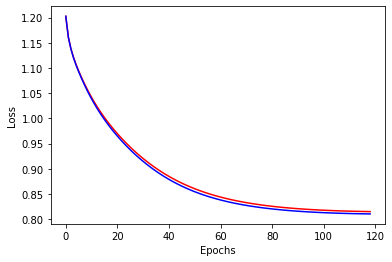

Epoch: 119, error: 0.8152085832633686, train accuracy: 0.7774, test accuracy: 0.7821


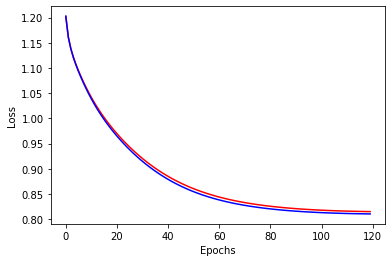

Epoch: 120, error: 0.8151385632373829, train accuracy: 0.7780833333333333, test accuracy: 0.7836


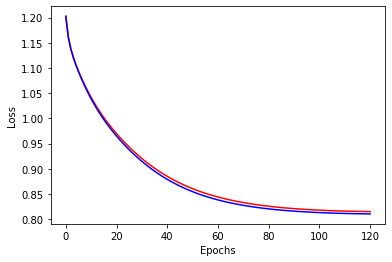

Epoch: 121, error: 0.8150745017221263, train accuracy: 0.77915, test accuracy: 0.7842


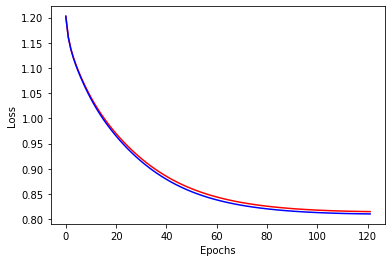

Epoch: 122, error: 0.8150161983572347, train accuracy: 0.7800166666666667, test accuracy: 0.785


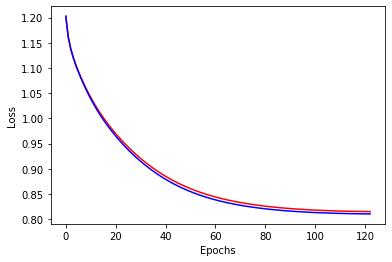

Epoch: 123, error: 0.8149634589286675, train accuracy: 0.781, test accuracy: 0.7855


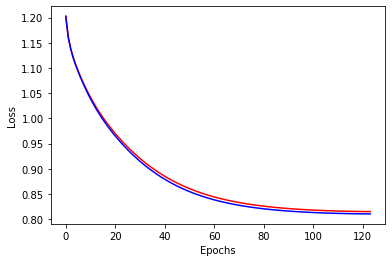

Epoch: 124, error: 0.8149160951300907, train accuracy: 0.7819666666666667, test accuracy: 0.786


In [209]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

X_train, y_train = load_file(path_train)
assert X_train.shape == (784, 60000)
assert y_train.shape == (1, 60000)
X_test, y_test = load_file(path_test)
assert X_test.shape == (784, 10000)
assert y_test.shape == (1, 10000)
X_train = scale_values(X_train)
assert X_train.shape == (784, 60000)
X_test = scale_values(X_test)
assert X_test.shape == (784, 10000)

optimal_arch = [architecture[0], hidden_layer_sizes[idx_error_min], architecture[2]]
W, b = create_weights(optimal_arch)
W, b, errors_train, acc_train, acc_test = train(optimal_arch, X_train, y_train, X_test, y_test, 10, W, b, f, 0.01, 0.5, 5e-5)

In [211]:
print(f'Accuracy on train set: {accuracy(X_train, y_train, W, b, f)}')
print(f'Accuracy on test set: {accuracy(X_test, y_test, W, b, f)}')

Accuracy on train set: 0.7819666666666667
Accuracy on test set: 0.786
